<a href="https://colab.research.google.com/github/mansi2420/Song_generator_RNN/blob/main/song_generate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


**Imports**

In [5]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adamax
import sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Loading the data
In this section, I will load the Spotify data into a dataframe, the data will have fields having artist name and lyrics, that I will further use to train the RNN model.

In [6]:
song_df = pd.read_csv('/content/drive/My Drive/song_gen/spotify_millsongdata.csv')

In [7]:
song_df.drop(columns = 'link', inplace = True) #link field is irrelevant for my purpose
song_df.head()

,artist,song,text
0,ABBA,Ahe's My Kind Of Girl,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante","Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,Making somebody happy is a question of give an...


In [8]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   text    57650 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [9]:
#removing all tabs from scraped lyrics
song_df['text'] = song_df['text'].str.replace('\n', '', regex=False).str.replace('\r', '', regex=False)

In [10]:
song_df['text']

,text
0,"Look at her face, it's a wonderful face And i..."
1,"Take it easy with me, please Touch me gently ..."
2,I'll never know why I had to go Why I had to ...
3,Making somebody happy is a question of give an...
4,Making somebody happy is a question of give an...
...,...
57645,Irie days come on play Let the angels fly let...
57646,Power to the workers More power Power to the...
57647,all you need is something i'll believe flash...
57648,northern star am i frightened where can i go...


In [11]:
unique_artists = song_df['artist'].str.lower().unique()
#print(unique_artists)

# Preprocessing the Data
In this section, I will extract the records of a particular artist, that is because training and working with a data of million records would take a heavy toll on the code, as well as I wanted to see if it mimics the writing style of a particular artist.

In [12]:
artist = input('Pick an artist for training data:').strip().lower()

Pick an artist for training data:bon joviE


In [13]:
import difflib

# Find the closest match to the user input
closest_matches = difflib.get_close_matches(artist, unique_artists, n=1, cutoff=0.6)
#print(closest_matches)

if closest_matches:
    closest_match = closest_matches[0]
    artist_data = song_df[song_df['artist'].str.lower() == closest_match]
    print(f"Did you mean '{closest_match.title()}'? Here is the data for that artist:")
    print(artist_data.head())
    print(artist_data.size)
else:
    print(f'Artist {artist} not found, try another name!')

Did you mean 'Bon Jovi'? Here is the data for that artist:
        artist                                 song  \
1721  Bon Jovi  Ain't No Cure For Love (Crush Demo)   
1722  Bon Jovi                                Alive   
1723  Bon Jovi                 All About Loving You   
1724  Bon Jovi                All I Wanna Do Is You   
1725  Bon Jovi             All I Want Is Everything   

                                                   text  
1721  Aint no cure for love  Aint no cure for love  ...  
1722  Feel me like I feel you  Won't you let me come...  
1723  Looking at the pages of my life  Faded memorie...  
1724  Working hard eight days a week  Most days we'v...  
1725  Some fifteen year old kid sits on his porch  J...  
543


In [14]:
import re
corpus = ''
for word in artist_data['text']:
    corpus += word
corpus = corpus.lower()
corpus = re.sub(r'[^0-9a-z\s]', '', corpus) #removing all special characters
print("Number of characters:", len(corpus))
print("Number of unique characters:", len(set(corpus)))

Number of characters: 239964
Number of unique characters: 37


In [15]:
#list(set(corpus))

In [16]:
artist_data.loc[:, 'text_length'] = artist_data['text'].apply(len)

average_length = artist_data['text_length'].mean()

print(f"The average length of songs  is {average_length:.2f} characters.")

The average length of songs  is 1362.53 characters.


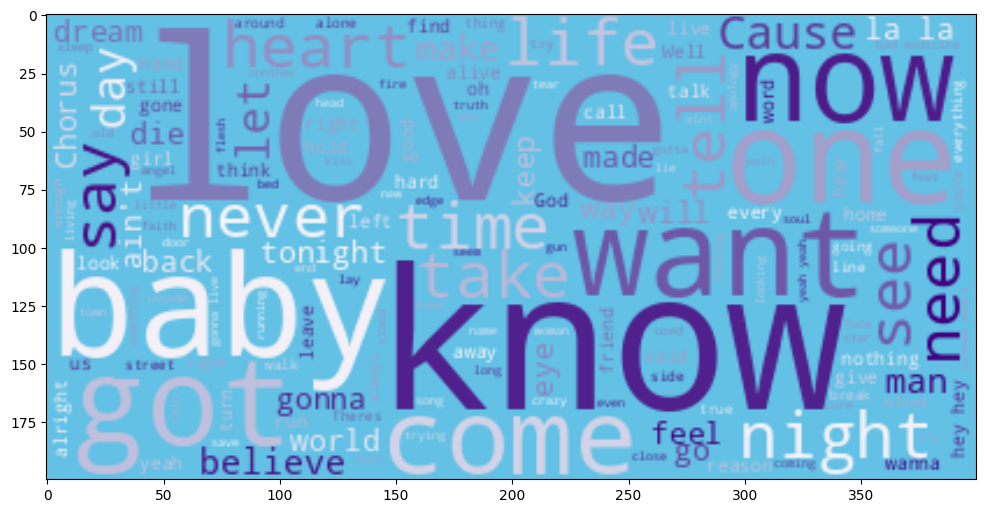

In [17]:
#wordcloud to see most frequently occuring words
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="#62c1e5",colormap="Purples", max_words=400).generate(" ".join(artist_data['text']))
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [18]:
features = []
targets = []
chars = sorted(list(set(corpus)))

len_corpus = len(corpus)
len_chars = len(chars)

mapp = dict((c, i) for i, c in enumerate(chars))
reverse_map = dict((i, c) for i, c in enumerate(chars))
l = 50

for i in range(0, len_corpus - l, 1):
    f = corpus[i:i + l]
    t = corpus[i + l]
    features.append([mapp[j] for j in f])
    targets.append(mapp[t])


print("Total number of sequences in the Corpus:", len(targets))

x = (np.reshape(features, (len(targets), l, 1)))/ float(len_chars)
y = to_categorical(targets)

Total number of sequences in the Corpus: 239914


# Training the data

In [19]:
'''%load_ext tensorboard
%tensorboard --logdir logs'''

'%load_ext tensorboard\n%tensorboard --logdir logs'

In [20]:
'''model = Sequential()

model.add(LSTM(256, input_shape=(x.shape[1], x.shape[2])))
model.add(Dense(y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer= Adamax(learning_rate=0.001))

model.summary()'''

"model = Sequential()\n\nmodel.add(LSTM(256, input_shape=(x.shape[1], x.shape[2])))\nmodel.add(Dense(y.shape[1], activation='softmax'))\nmodel.compile(loss='categorical_crossentropy', optimizer= Adamax(learning_rate=0.001))\n\nmodel.summary()"

In [21]:
#setting up tensorboard to keep clean track of logs
#tensorboard_callback = TensorBoard(log_dir="logs", histogram_freq=1)

#Model = model.fit(x, y, batch_size=128, epochs=100, callbacks = [tensorboard_callback])

In [22]:
#model.save('song_gen.h5')

In [23]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/song_gen/song_gen.h5')

In [24]:
def Lyrics(first_line, char):
    song = first_line
    seed = [mapp[c] for c in first_line]

    for _ in range(char):
        x_pred = np.reshape(seed, (1, len(seed), 1)) / float(len_chars)
        prediction = model.predict(x_pred, verbose=0)[0]
        prediction = np.exp(np.log(prediction)) / np.sum(np.exp(np.log(prediction)))
        next_char = reverse_map[np.argmax(prediction)]

        song += next_char
        seed = seed[1:] + [mapp[next_char]]

    return song


song = Lyrics("here comes the sun and i say its alright", 500)
song

'here comes the sun and i say its alright ln the sore  never siy mooely to the eke oh the dort    lesee soaye the pishrgo sels of    coot you knlw that i fan aeey tore    col yhu worr long uo ger  ween you giartnd rona  noe doou lide to have to be    caby ime iev gor your love  if i couldne mave moghtsiog  toveo yhah yerl piver  in aod out oo hone  clt hear is aro ot hend to anl the oon    ih gonna you  do rivelggz night  to tuu to your eeel op my bieen  bot yhu wace it saem tt bel oa baby that wiul leat  when youre in me she cea    cl'

# Final Insight
A lot can be improved here in the future, I aim aiming to focus on better preprocessing and training for the data and possibly get a sensible output.

Other thing can be, currently it's specifically trained on Bon Jovi lyrics, I would prefer to train it on diverse data and then geet specific artist lyrics